In [1]:
import pandas as pd
from database.connect import getConnection
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import seaborn as sns
sns.set()
from pathlib import Path

from processes.reply4_3 import reply_set_up, split_df, welch_test

/Users/alicialarsen/anaconda3/envs/ok/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# **CLEAR OUTPUTS BEFORE PUSHING TO GIT**
Press the clear all outputs button in the toolbar above before pushing to git.  
This makes version control easier and avoids merge conflicts. 

In [2]:
start_date = '01-01-2000'
end_date = '01-01-2023'

# convert start and end date to unix timestamp in milliseconds
start_date_unix = int(datetime.strptime(start_date, '%d-%m-%Y').timestamp() * 1000)
end_date_unix = int(datetime.strptime(end_date, '%d-%m-%Y').timestamp() * 1000)

# create a part you can insert into your where clause
date_restriction = f" AND tweets.timestamp_ms >= {start_date_unix} AND tweets.timestamp_ms <= {end_date_unix}"

The cell below creates the connection to the database and the cursor to execute queries.  
It also contains variables relevant everywhere in the notebook.

In [21]:
try:
    connection = getConnection()
except Exception:
    print("✖️ Error while connecting to MySQL engine database.")
    print("ℹ️ Please make sure the environment file `.env` is located at"+
        "the project root directory and contains proper configuration.")
    raise

cursor = connection.cursor()

categories = {'booking': ['booking', 'booked', 'book', 'ticket', 'tickets'],
            'canceling': ['canceled', 'cancellations'],
            'money': ['refund', 'compensation', 'claim', 'money', 'pay', 'paid'],
            'baggage': ['bag', 'baggage', 'luggage', 'bags'],
            'staff': ['staff', 'crew'],
            'waiting': ['waiting', 'delay', 'wait'],
            'boarding': ['boarding'],
            'stuck': ['stuck'],

            'information': ['info', 'information'],
            'customers': ['customer', 'customers', 'passenger', 'passengers'],
            'dm': [' dm'], 
            }

airlines_dict = {'KLM': ['klm'],
                'AirFrance':['airfrance',
                            'air france'],
                'British_Airways': ['british_airways',
                                    'british airways'],
                'AmericanAir': ['americanair',
                                'american airlines'],
                'Lufthansa': ['lufthansa'],
                'AirBerlin': ['airberlin',
                                'air berlin'],
                'AirBerlin assist': ['airberlin assist',
                                    'air berlin assist',
                                    'airberlinassist'],
                'easyJet': ['easyjet'],
                'RyanAir': ['ryanair'],
                'SingaporeAir': ['singaporeair',
                                'singapore airlines'],
                'Qantas': ['qantas'],
                'EtihadAirways': ['etihad airways',
                                'etihadairways',
                                'etihad'],
                'VirginAtlantic': ['virgin atlantic',
                                    'virginatlantic'],
            }

airlines_of_interest = ['AmericanAir', 'Other', 'British_Airways']

In [22]:
# create a dataframe with the counts of each category
excluided = ['dm', 'customers', 'information']
relevant_categories = [key for key in categories.keys() if key not in excluided]
columns = ['total'] + relevant_categories

base_path = Path('./pre-processed/')

# create a dataframe with the counts of each category, restricted by timestamp_ms
df = pd.DataFrame(columns=columns)
for airline in airlines_of_interest:
    df_airline = pd.read_csv(base_path / f'{airline}_category_counts.csv')
    length = len(df_airline.index)
    df_airline = df_airline[df_airline['timestamp_ms'] >= start_date_unix]
    df_airline = df_airline[df_airline['timestamp_ms'] <= end_date_unix]
    df_airline = df_airline.sum().to_frame().T
    df_airline['total'] = length
    df_airline['airline'] = airline
    df = pd.concat([df, df_airline])


df_category_counts = df.set_index('airline')

In [23]:
# turn the dataframe into a table that shows both the counts, aswell as the keywords
df_category_counts_table = df_category_counts.copy()
df_category_counts_table = df_category_counts_table.drop(columns=['total'])
df_category_counts_table = df_category_counts_table.transpose()
df_category_counts_table = df_category_counts_table.reset_index()
df_category_counts_table = df_category_counts_table.rename(columns={'index': 'category'})
df_category_counts_table = df_category_counts_table.set_index('category')

# add a column that displays the keywords for each category
for category in relevant_categories:
    keywords = categories[category]
    df_category_counts_table.loc[category, 'keywords'] = ", ".join(keywords)

df_category_counts_table

airline,AmericanAir,Other,British_Airways,keywords
category,,,,
booking,29180,156547,53911,"booking, booked, book, ticket, tickets"
canceling,4775,11383,2303,"canceled, cancellations"
money,25367,164869,34256,"refund, compensation, claim, money, pay, paid"
baggage,26042,94871,22776,"bag, baggage, luggage, bags"
staff,14662,65115,17726,"staff, crew"
waiting,46004,119934,34814,"waiting, delay, wait"
boarding,5559,18579,3376,boarding
stuck,3374,13510,2150,stuck
timestamp_ms,538195075857027008.0,2641845021756311040.0,484864832417714112.0,NaN


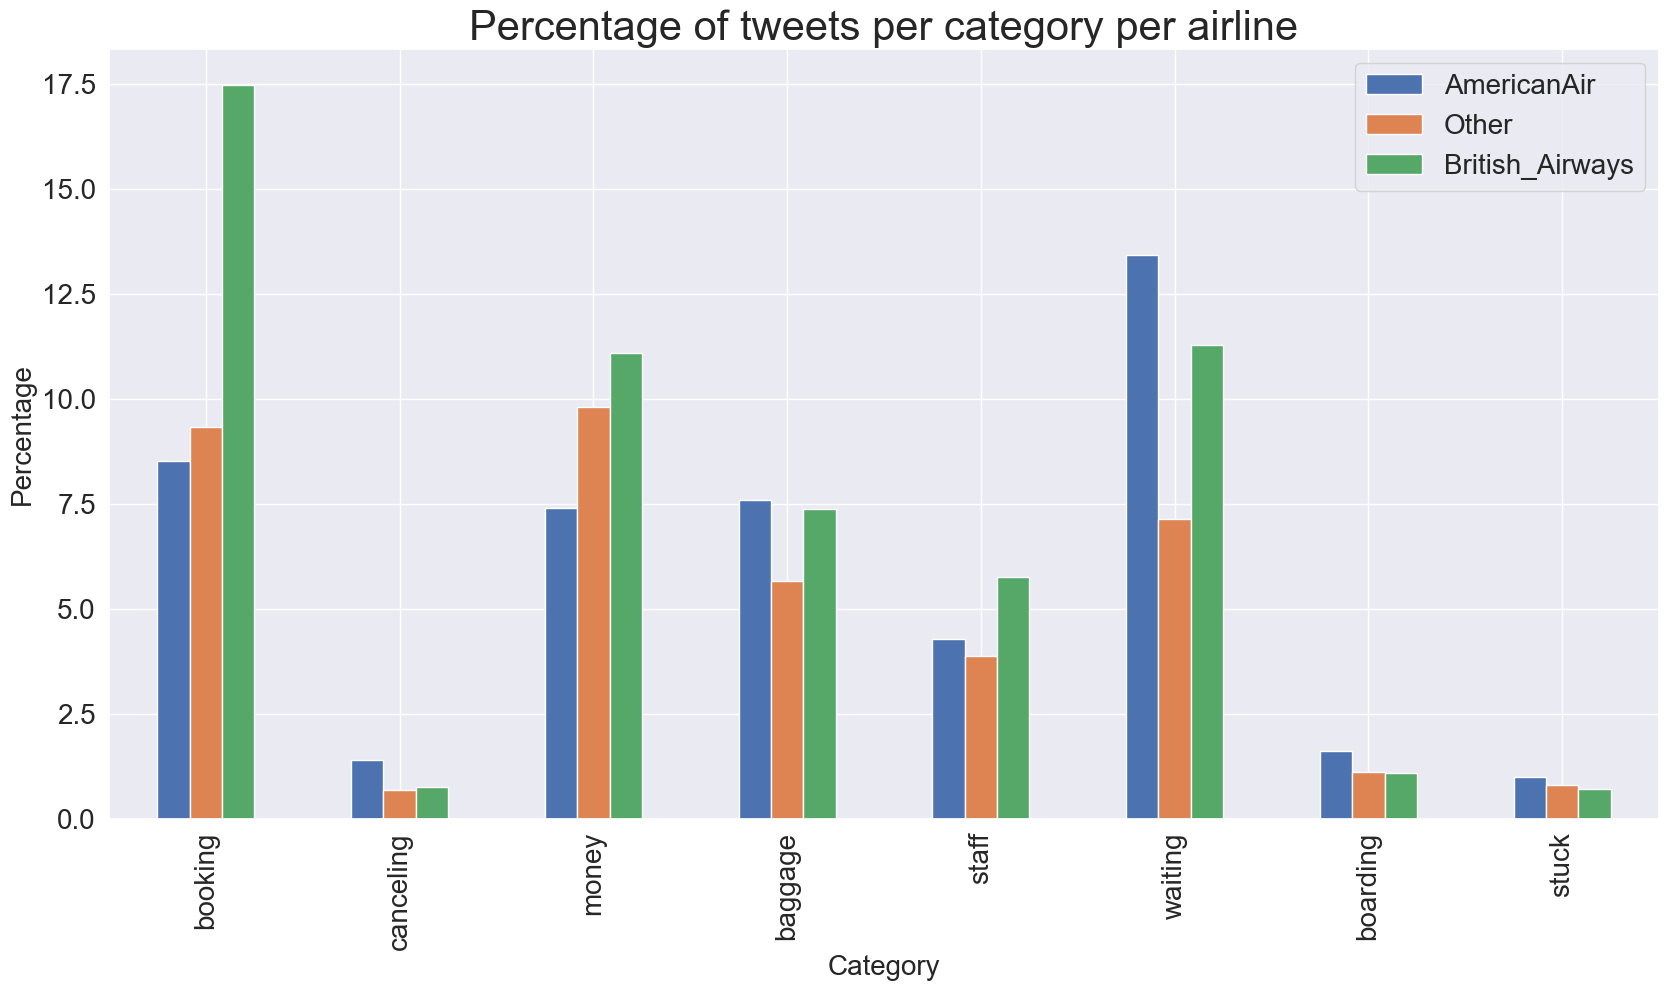

In [24]:
# create a dataframe for the percentages
df_category_percentages = pd.DataFrame(columns=relevant_categories)

# create rows for each airline and initialize with NaN values
for airline in airlines_of_interest:
    df_category_percentages.loc[airline] = np.nan


# calculate the percentage of each category, restricted to 2 decimal points
for category in relevant_categories:
    if category == 'total':
        continue
    for airline in airlines_of_interest:
        raw_percentage = df_category_counts.loc[airline][category] / df_category_counts.loc[airline]['total'] * 100
        percentage = round(raw_percentage, 2)
        df_category_percentages.loc[airline, category] = percentage

# Convert relevant columns to numeric type
df_category_percentages[relevant_categories] = df_category_percentages[relevant_categories].apply(pd.to_numeric)


# create a grouped bar chart 
# df_category_percentages.plot.bar(figsize=(20, 10), fontsize=20)
# plt.title('Percentage of tweets per category', fontsize=30)
# plt.xlabel('Airline', fontsize=20)
# plt.ylabel('Percentage', fontsize=20)
# plt.legend(fontsize=20)
# plt.show()

# create a grouped bar chart grouped by category
df_category_percentages.transpose().plot.bar(figsize=(20, 10), fontsize=20)
plt.title('Percentage of tweets per category per airline', fontsize=30)
plt.xlabel('Category', fontsize=20)
plt.ylabel('Percentage', fontsize=20)
plt.legend(fontsize=20)
plt.show()

### Sentiment evolution in conversations (Oscar)

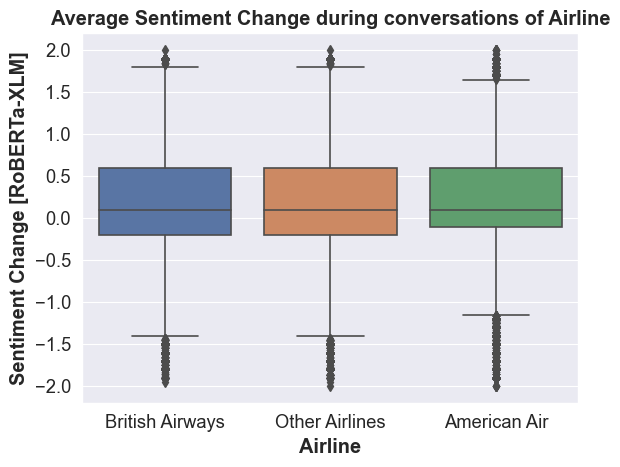

In [25]:
cursor.execute(f""" SELECT bs.bin_id, bs.cID, bs.bin_position, bs.break_airline, bs.sentiment_sum, bs.tweet_count, c.Tstart, c.Tend
                    FROM binned_sentiment bs, conversations c
                    WHERE bs.cID = c.id AND bs.break_airline NOT LIKE 'prev=%'""")
binned_sentiment = cursor.fetchall()
#all bins from conversations with more than 1 bin.

query = f""" SELECT CASE WHEN bs1.break_airline='AmericanAir' THEN "American Air" 
                        WHEN bs1.break_airline = 'British_Airways' THEN "British Airways" 
                        ELSE "Other Airlines" END AS Airline, 
            CASE WHEN (bs1.sentiment_sum / bs1.tweet_count) > (bs2.sentiment_sum / bs2.tweet_count) THEN -1*ABS((bs1.sentiment_sum / bs1.tweet_count) - (bs2.sentiment_sum / bs2.tweet_count))
            ELSE ABS((bs1.sentiment_sum / bs1.tweet_count) - (bs2.sentiment_sum / bs2.tweet_count))
            END AS Average_sent_diff
            FROM `binned_sentiment` bs1, `binned_sentiment` bs2
            WHERE bs1.cID = bs2.cID AND bs2.bin_position = bs1.bin_position + 1 
            AND bs1.cID IN (SELECT id
                            FROM conversations
                            WHERE Tstart > {start_date_unix} AND Tend < {end_date_unix})"""
cursor.execute(query) #the airlines and average sentiment change per 
sentiment_change = cursor.fetchall()

df_sentiment_change = pd.DataFrame(sentiment_change)
df_sentiment_change.rename(columns ={0:"Airline",1:"Sentiment Change [RoBERTa-XLM]"}, inplace=True)
df_sentiment_change["Sentiment Change [RoBERTa-XLM]"] = df_sentiment_change["Sentiment Change [RoBERTa-XLM]"].astype(float)
#initialize a dataframe with the query data.

sns.set_context("paper", font_scale = 1.5)
ax = sns.boxplot(data=df_sentiment_change,x='Airline',y='Sentiment Change [RoBERTa-XLM]', order= ['British Airways','Other Airlines','American Air'
            ])
ax.set_xlabel(ax.get_xlabel(), fontdict={'weight':'bold'})
ax.set_ylabel(ax.get_ylabel(), fontdict={'weight':'bold'})
ax.set_title('Average Sentiment Change during conversations of Airline',weight='bold'); #graph the data from the dataframe into 3 boxplots

In [9]:
cursor.close()
connection.close()

### Sentiment Change over reply-time per topic
All functions found in processes.reply4_3.py

In [10]:
"""
Create dataframe from SQL query
NOTE: make sure to have the right data-base.
--> Expected running time: 20 sec
"""
df_tweets = reply_set_up()
#df_tweets.head()

In [11]:
"""Convert sentiment score to pos, neu, neg"""

# Bin column sentiment1 (first bin) -> (pos=1, neu=0, neg=-1)
df_tweets.loc[df_tweets['sentiment1'] < -0.2, 'sentiment1'] = -1
df_tweets.loc[df_tweets['sentiment1'] > -0.2, 'sentiment1'] = 1
df_tweets.loc[(df_tweets['sentiment1']  >= -0.2) & (df_tweets['sentiment1'] <= 0.2), 'sentiment1'] = 0

# Bin column sentiment2 (second bin) -> (pos=1, neu=0, neg=-1)
df_tweets.loc[df_tweets['sentiment2'] < -0.2, 'sentiment2'] = -1
df_tweets.loc[df_tweets['sentiment2'] > -0.2, 'sentiment2'] = 1
df_tweets.loc[(df_tweets['sentiment2']  >= -0.2) & (df_tweets['sentiment2'] <= 0.2), 'sentiment2'] = 0

#df_tweets.head()

In [12]:
# Calculate the difference between sentiment 1 and 2

df_tweets['sentiment_change'] = df_tweets['sentiment2'] - df_tweets['sentiment1']
#df_tweets.head()

In [13]:
""""
Clearing the data frames.
"""

# Creating a data frame per topic
df_canceling = df_tweets[df_tweets['canceling'] != 0][['reply_time', 'sentiment_change']]
df_boarding = df_tweets[df_tweets['boarding'] != 0][['reply_time', 'sentiment_change']]
df_stuck = df_tweets[df_tweets['stuck'] != 0][['reply_time', 'sentiment_change']]
df_booking = df_tweets[df_tweets['booking'] != 0][['reply_time', 'sentiment_change']]
df_customers = df_tweets[df_tweets['customers'] != 0][['reply_time', 'sentiment_change']]
df_dm = df_tweets[df_tweets['dm'] != 0][['reply_time', 'sentiment_change']]
df_waiting = df_tweets[df_tweets['waiting'] != 0][['reply_time', 'sentiment_change']]
df_money = df_tweets[df_tweets['money'] != 0][['reply_time', 'sentiment_change']]
df_information = df_tweets[df_tweets['information'] != 0][['reply_time', 'sentiment_change']]
df_staff = df_tweets[df_tweets['staff'] != 0][['reply_time', 'sentiment_change']]
df_baggage = df_tweets[df_tweets['baggage'] != 0][['reply_time', 'sentiment_change']]


# Binned of 1 min
df_canceling_gro = df_canceling[['reply_time', 'sentiment_change']].groupby('reply_time').agg('mean').rolling(window=15).mean()
df_boarding_gro = df_boarding[['reply_time', 'sentiment_change']].groupby('reply_time').agg('mean').rolling(window=15).mean()
df_stuck_gro = df_stuck[['reply_time', 'sentiment_change']].groupby('reply_time').agg('mean').rolling(window=15).mean()
df_booking_gro = df_booking[['reply_time', 'sentiment_change']].groupby('reply_time').agg('mean').rolling(window=15).mean()
df_customers_gro = df_customers[['reply_time', 'sentiment_change']].groupby('reply_time').agg('mean').rolling(window=15).mean()
df_dm_gro = df_dm[['reply_time', 'sentiment_change']].groupby('reply_time').agg('mean').rolling(window=15).mean()
df_waiting_gro = df_waiting[['reply_time', 'sentiment_change']].groupby('reply_time').agg('mean').rolling(window=15).mean()
df_money_gro = df_money[['reply_time', 'sentiment_change']].groupby('reply_time').agg('mean').rolling(window=15).mean()
df_information_gro = df_information[['reply_time', 'sentiment_change']].groupby('reply_time').agg('mean').rolling(window=15).mean()
df_staff_gro = df_staff[['reply_time', 'sentiment_change']].groupby('reply_time').agg('mean').rolling(window=15).mean()
df_baggage_gro = df_baggage[['reply_time', 'sentiment_change']].groupby('reply_time').agg('mean').rolling(window=15).mean()

In [14]:
# Checking the number ineach category

canceling_len = len(df_canceling.index)
boarding_len = len(df_boarding.index)
stuck_len = len(df_stuck.index)
booking_len = len(df_booking.index)
customers_len = len(df_customers.index)
dm_len = len(df_dm.index)
waiting_len = len(df_waiting.index)
money_len = len(df_money.index)
information_len = len(df_information.index)
staff_len = len(df_staff.index)
baggage_len = len(df_baggage.index)

print(f"""
      TOPIC COUNT
      canceling: {canceling_len}
      boarding: {boarding_len}
      stuck: {stuck_len}
      booking: {booking_len}
      customers: {customers_len}
      dm: {dm_len}
      waiting: {waiting_len}
      money: {money_len}
      information: {information_len}
      staff: {staff_len}
      baggage: {baggage_len}
      """)


      TOPIC COUNT
      canceling: 3379
      boarding: 5291
      stuck: 3047
      booking: 37152
      customers: 35777
      dm: 28427
      waiting: 32513
      money: 29894
      information: 27696
      staff: 17359
      baggage: 19124
      


In [15]:
# Get quantiles of the most relevant topics
baggage_qua5 = df_baggage['reply_time'].astype(float).quantile([0, 0.25, 0.5, 0.75, 1])
boarding_qua5 = df_boarding['reply_time'].astype(float).quantile([0, 0.25, 0.5, 0.75, 1])
booking_qua5 = df_booking['reply_time'].astype(float).quantile([0, 0.25, 0.5, 0.75, 1])
information_qua5 = df_information['reply_time'].astype(float).quantile([0, 0.25, 0.5, 0.75, 1])
money_qua5 = df_money['reply_time'].astype(float).quantile([0, 0.25, 0.5, 0.75, 1])
waiting_qua5 = df_waiting['reply_time'].astype(float).quantile([0, 0.25, 0.5, 0.75, 1])

In [16]:
# Data frames, split by quantiles, for every topic
df_baggage_4 = split_df(df_baggage, baggage_qua5)
df_boarding_4 = split_df(df_boarding, boarding_qua5)
df_booking_4 = split_df(df_booking, booking_qua5)
df_information_4 = split_df(df_information, information_qua5)
df_money_4 = split_df(df_money, money_qua5)
df_waiting_4 = split_df(df_waiting, waiting_qua5)

In [17]:
# Calculate p-values for different quantiles and topics
# Return a dataframe with all p-values
p_baggage = welch_test(df_baggage_4, 'baggage')
p_boarding = welch_test(df_boarding_4, 'boarding')
p_booking = welch_test(df_booking_4, 'booking')
p_information = welch_test(df_information_4, 'information')
p_money = welch_test(df_money_4, 'money')
p_waiting = welch_test(df_waiting_4, 'waiting')

ds = [p_baggage, p_boarding, p_booking, p_information, p_money, p_waiting]

df_p = pd.DataFrame(ds)
df_p

,topic,25 vs. 50,50 vs. 75,75 vs. 100,low vs high
0,baggage,0.019331,0.642138,0.644479,0.277580
1,boarding,0.147583,0.078321,0.949495,0.069822
2,booking,0.091127,0.321984,0.081497,0.006050
3,information,0.049546,0.519686,0.248047,0.072344
4,money,0.081961,0.484752,0.057966,0.018762
5,waiting,0.015251,0.922800,0.195452,0.458432


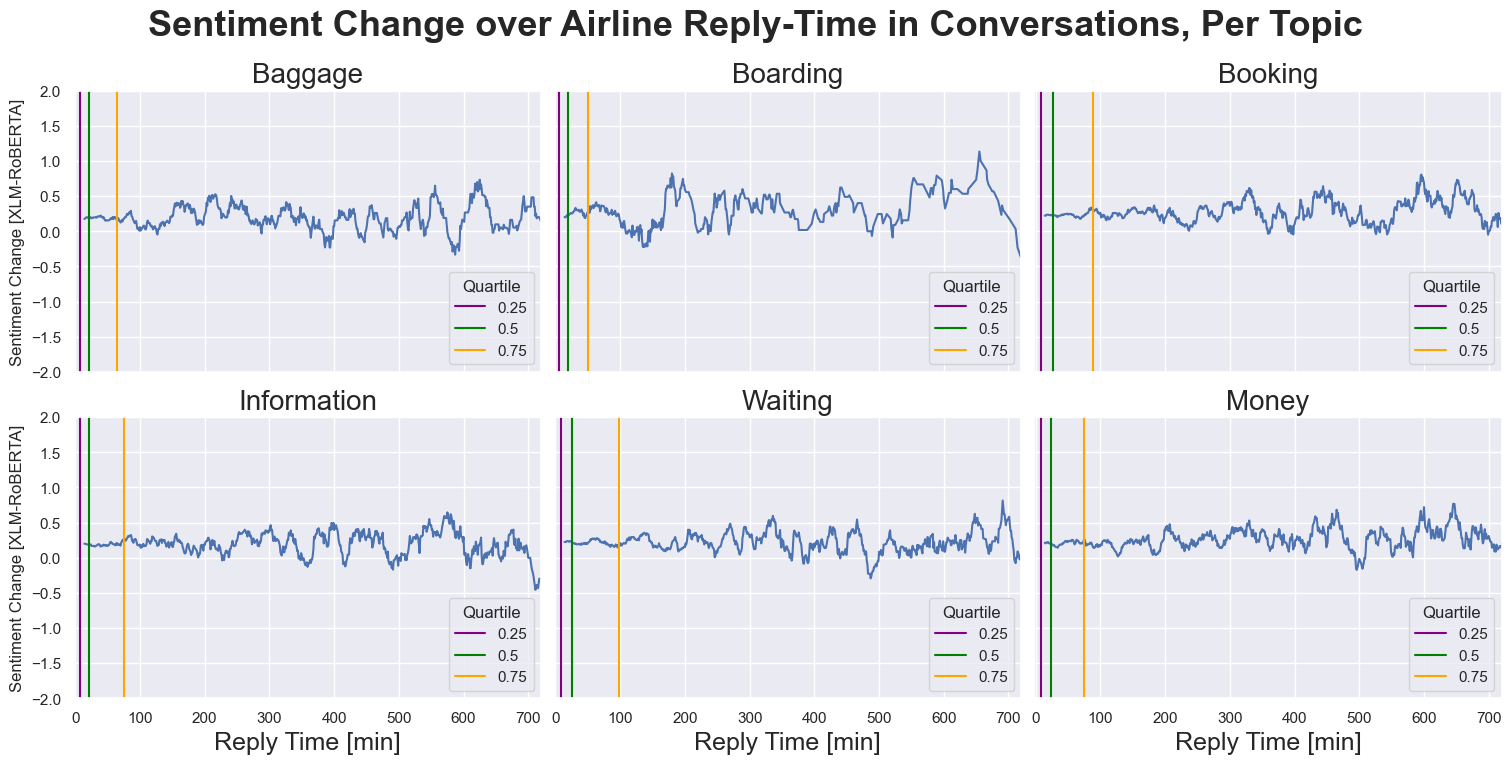

In [19]:
# Plot the results in line-plot with marked quantiles

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,7), sharey=True, sharex=True, layout="constrained")
plt.setp(ax, ylim=(-2,2))
plt.setp(ax, xlim=(-2,720))


# ROW 1
# Baggage
sns.lineplot(data=df_baggage_gro, x='reply_time', y='sentiment_change', ax=ax[0,0])
ax[0,0].axvline(x = baggage_qua5[0.25], c='purple', label='0.25')
ax[0,0].axvline(x = baggage_qua5[0.5], c='green', label='0.5')
ax[0,0].axvline(x = baggage_qua5[0.75], c='orange', label='0.75')
ax[0,0].legend(title = 'Quartile')
ax[0,0].set_title('Baggage', size=20)
ax[0,0].set_ylabel('Sentiment Change [XLM-RoBERTA]')

# Boarding
sns.lineplot(data=df_boarding_gro, x='reply_time', y='sentiment_change', ax=ax[0,1])
ax[0,1].axvline(x = boarding_qua5[0.25], c='purple', label='0.25')
ax[0,1].axvline(x = boarding_qua5[0.5], c='green', label='0.5')
ax[0,1].axvline(x = boarding_qua5[0.75], c='orange', label='0.75')
ax[0,1].legend(title = 'Quartile')
ax[0,1].set_title('Boarding', size=20)

# Booking
sns.lineplot(data=df_booking_gro, x='reply_time', y='sentiment_change', ax=ax[0,2])
ax[0,2].axvline(x = booking_qua5[0.25], c='purple', label='0.25')
ax[0,2].axvline(x = booking_qua5[0.5], c='green', label='0.5')
ax[0,2].axvline(x = booking_qua5[0.75], c='orange', label='0.75')
ax[0,2].legend(title = 'Quartile')
ax[0,2].set_title('Booking', size=20)

# ROW 2
# Information
sns.lineplot(data=df_information_gro, x='reply_time', y='sentiment_change', ax=ax[1,0])
ax[1,0].axvline(x = information_qua5[0.25], c='purple', label='0.25')
ax[1,0].axvline(x = information_qua5[0.5], c='green', label='0.5')
ax[1,0].axvline(x = information_qua5[0.75], c='orange', label='0.75')
ax[1,0].legend(title = 'Quartile')
ax[1,0].set_title('Information', size=20)
ax[1,0].set_xlabel('Reply Time [min]', size=18)
ax[1,0].set_ylabel('Sentiment Change [XLM-RoBERTA]')

# Waiting
sns.lineplot(data=df_waiting_gro, x='reply_time', y='sentiment_change', ax=ax[1,1])
ax[1,1].axvline(x = money_qua5[0.25], c='purple', label='0.25')
ax[1,1].axvline(x = money_qua5[0.5], c='green', label='0.5')
ax[1,1].axvline(x = money_qua5[0.75], c='orange', label='0.75')
ax[1,1].legend(title = 'Quartile')
ax[1,1].set_xlabel('Reply Time [min]', size=18)
ax[1,1].set_title('Waiting', size=20)

# Money
sns.lineplot(data=df_money_gro, x='reply_time', y='sentiment_change', ax=ax[1,2])
ax[1,2].axvline(x = waiting_qua5[0.25], c='purple', label='0.25')
ax[1,2].axvline(x = waiting_qua5[0.5], c='green', label='0.5')
ax[1,2].axvline(x = waiting_qua5[0.75], c='orange', label='0.75')
ax[1,2].legend(title = 'Quartile')
ax[1,2].set_title('Money', size=20)
ax[1,2].set_xlabel('Reply Time [min]', size=18)

fig.suptitle('Sentiment Change over Airline Reply-Time in Conversations, Per Topic', weight='bold', size=26, y=1.07);

### Sentiment Change in conversations (OSCAR):

In [20]:
cursor.execute(f""" SELECT bs.bin_id, bs.cID, bs.bin_position, bs.break_airline, bs.sentiment_sum, bs.tweet_count, c.Tstart, c.Tend
                    FROM binned_sentiment bs, conversations c
                    WHERE bs.cID = c.id AND bs.break_airline NOT LIKE 'prev=%'""")
binned_sentiment = cursor.fetchall()
#all bins from conversations with more than 1 bin.

query = f""" SELECT CASE WHEN bs1.break_airline='AmericanAir' THEN "American Air" 
                        WHEN bs1.break_airline = 'British_Airways' THEN "British Airways" 
                        ELSE "Other Airlines" END AS Airline, 
            CASE WHEN (bs1.sentiment_sum / bs1.tweet_count) > (bs2.sentiment_sum / bs2.tweet_count) THEN -1*ABS((bs1.sentiment_sum / bs1.tweet_count) - (bs2.sentiment_sum / bs2.tweet_count))
            ELSE ABS((bs1.sentiment_sum / bs1.tweet_count) - (bs2.sentiment_sum / bs2.tweet_count))
            END AS Average_sent_diff
            FROM `binned_sentiment` bs1, `binned_sentiment` bs2
            WHERE bs1.cID = bs2.cID AND bs2.bin_position = bs1.bin_position + 1 
            AND bs1.cID IN (SELECT id
                            FROM conversations
                            WHERE Tstart > {start_date_unix} AND Tend < {end_date_unix})"""
cursor.execute(query) #the airlines and average sentiment change per 
sentiment_change = cursor.fetchall()

df_sentiment_change = pd.DataFrame(sentiment_change)
df_sentiment_change.rename(columns ={0:"Airline",1:"Sentiment Change [RoBERTa-XLM]"}, inplace=True)
df_sentiment_change["Sentiment Change [RoBERTa-XLM]"] = df_sentiment_change["Sentiment Change [RoBERTa-XLM]"].astype(float)
#initialize a dataframe with the query data.

sns.set_context("paper", font_scale = 1.5)
ax = sns.boxplot(data=df_sentiment_change,x='Airline',y='Sentiment Change [RoBERTa-XLM]', order= ['British Airways','Other Airlines','American Air'
            ])
ax.set_xlabel(ax.get_xlabel(), fontdict={'weight':'bold'})
ax.set_ylabel(ax.get_ylabel(), fontdict={'weight':'bold'})
ax.set_title('Average Sentiment Change during conversations of Airline',weight='bold'); #graph the data from the dataframe into 3 boxplots

ProgrammingError: Cursor is not connected